In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.visualization import plot_histogram
%matplotlib

C:\Users\coleb\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\coleb\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

Using matplotlib backend: Qt5Agg


# Variational Quantum Classifier

This will be a Variational Quantum Classifier based on the paper
https://arxiv.org/pdf/2010.07335.pdf

In this paper, they break up the process of quantum classification into 3 stages:
1. State Preparation - Essentially Rotating Data into the correct format
2. Model Circuit - Runs the model through trainable and non-trainable gates
3. Measurement and Postprocessing - Does measurement and recalculates weights on a classical computer

## State Preparation

State preparation involves encoding data using the RYGate so that we can prep the data for input

In [2]:
def Sx(thetas):
    circ = QuantumCircuit(len(thetas), 1)
    for i in range(len(thetas)):
        circ.ry(2*thetas[i], i)
    return circ

## Model Circuit

The model circuit stacks multiply layers of trainable parameters together for classification

In [3]:
# alphas, betas, gammas are matrices with N rows and l cols where
# N is the number of qubits and l is the number of layers
def U(alphas, betas, gammas):
    if alphas.shape != betas.shape or betas.shape != gammas.shape:
        raise Exception("Input parameters do not have match shapes")
    if len(alphas) <= 1:
        raise Exception("Must have at least two qubits")
    circ = QuantumCircuit(len(alphas), 1)
    # Assume non jagged arrays, we want to iterate on number of layers then
    # number of qubits
    for i in range(len(alphas[0])):
        for j in range(len(alphas)):
            circ.rz(gammas[j,i], j)
            circ.ry(betas[j,i], j)
            circ.rz(alphas[j,i], j)
        # Currently unsure how to support more than 2 qubits for this part
        # For now, assuming exactly two qubits
        circ.cx(0, 1)
        circ.cx(1, 0)
    return circ

## Measurement and Postprocessing

Here we create a basic circuit to measure the circuit to get the output and 

In [4]:
# Doing this as a separate function because we may want to generalize for
# a multi-class classifier later
# N is the number of qubits
def measurement(N):
    circ = QuantumCircuit(N, 1)
    circ.z(0) # I am pretty sure this is required
    circ.measure([0], [0])
    return circ

In [5]:
def pi(thetas, alphas, betas, gammas, bias, shots=2048):
    # Create the simulator backend
    backend = Aer.get_backend("qasm_simulator")
    # Build the circuit
    sx   = Sx(thetas)
    u    = U(alphas, betas, gammas)
    meas = measurement(N)
    circ = sx + u + meas
    # Execute the job
    job = execute(circ, backend, shots=shots)
    res = job.result()
    counts = res.get_counts()
    if '0' not in counts:
        counts['0'] = 0
    if '1' not in counts:
        counts['1'] = 0
    return counts['0']/shots - counts['1']/shots, counts

## Putting it all together

C:\Users\coleb\Anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
C:\Users\coleb\Anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

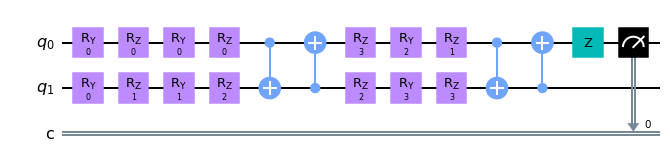

In [6]:
# Testing to make sure the circuit builds properly
N = 2
thetas = np.array([0, 0])
alphas = np.array([[0, 1], [2, 3]])
betas  = np.array([[0, 2], [1, 3]])
gammas = np.array([[0, 3], [1, 2]])
sx   = Sx(thetas)
u    = U(alphas, betas, gammas)
meas = measurement(N)

circ = sx + u + meas
circ.draw("mpl")

In [7]:
# Testing to see if I get valid output from classify
expectationVal, counts = pi(thetas, alphas, betas, gammas, 0)

C:\Users\coleb\Anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
C:\Users\coleb\Anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

Expectation Value: -0.5625


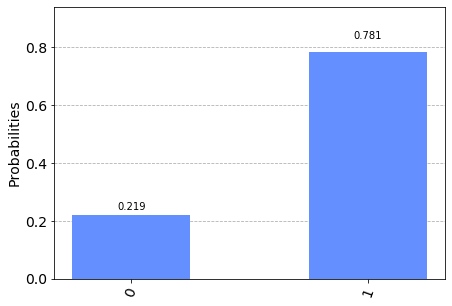

In [8]:
print("Expectation Value: {}".format(expectationVal))
plot_histogram(counts)